Libraries install

In [1]:
pip install torch

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Haris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Haris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Haris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Haris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Apply SimCLR Model

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.utils import resample


Load and Normalize the Data

In [6]:
import torch
import numpy as np

# Load the training data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

# Normalize the data
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)


Define Data Augmentation for Tabular Data

In [7]:
# Data augmentation for tabular data (Add Gaussian noise and masking)
def augment_data(X, noise_factor=0.1):
    X_noisy = X + noise_factor * torch.randn_like(X)
    X_masked = X.clone()
    mask = torch.rand_like(X_masked) < 0.1
    X_masked[mask] = 0
    return X_noisy, X_masked


Define the Encoder (MLP)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


Define the Projection Head

In [9]:
# Define the projection head
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc2 = nn.Linear(output_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


Define the NT-Xent Loss (Contrastive Loss)

In [10]:
# Contrastive Loss (NT-Xent Loss)
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.shape[0]
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)
    representations = torch.cat([z_i, z_j], dim=0)

    similarity_matrix = torch.matmul(representations, representations.T)
    sim_ij = torch.diag(similarity_matrix, batch_size)
    sim_ji = torch.diag(similarity_matrix, -batch_size)

    positives = torch.cat([sim_ij, sim_ji], dim=0)
    
    negatives_mask = torch.ones_like(similarity_matrix) - torch.eye(2 * batch_size).to(similarity_matrix.device)
    negatives = torch.exp(similarity_matrix / temperature) * negatives_mask
    denominator = torch.sum(negatives, dim=1)
    
    loss = -torch.log(torch.exp(positives / temperature) / denominator)
    return loss.mean()


Define the SimCLR Model

In [11]:
# Define the SimCLR model
class SimCLR(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, projection_dim):
        super(SimCLR, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, output_dim)
        self.projection_head = ProjectionHead(output_dim, projection_dim)
    
    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return h, z


Initialize the Model and Optimizer

In [12]:
import torch.optim as optim

# Initialize the model
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 64
projection_dim = 32

model = SimCLR(input_dim, hidden_dim, output_dim, projection_dim)

# Optimizer and hyperparameters
optimizer = optim.Adam(model.parameters(), lr=3e-4)
temperature = 0.5
epochs = 100
batch_size = 256


Define the Training Loop

In [13]:
# Training loop
def train_simclr(model, X_train, epochs, batch_size, temperature):
    model.train()
    
    dataset = torch.utils.data.TensorDataset(X_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            X_batch = batch[0]
            
            # Apply augmentations
            X1, X2 = augment_data(X_batch)
            
            # Forward pass
            _, z1 = model(X1)
            _, z2 = model(X2)
            
            # Compute loss
            loss = nt_xent_loss(z1, z2, temperature)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")


Train the Model

In [14]:
#Train the SimCLR model
train_simclr(model, X_train, epochs, batch_size, temperature)


Epoch 1/100, Loss: 4.527268417593173
Epoch 2/100, Loss: 4.405205805457031
Epoch 3/100, Loss: 4.382674578975883
Epoch 4/100, Loss: 4.371932738458352
Epoch 5/100, Loss: 4.3646869707376075
Epoch 6/100, Loss: 4.359438300804083
Epoch 7/100, Loss: 4.355673640367012
Epoch 8/100, Loss: 4.352532294136041
Epoch 9/100, Loss: 4.350457641067567
Epoch 10/100, Loss: 4.348960020613114
Epoch 11/100, Loss: 4.347118079230753
Epoch 12/100, Loss: 4.345706321496879
Epoch 13/100, Loss: 4.34488938071511
Epoch 14/100, Loss: 4.344104029148314
Epoch 15/100, Loss: 4.3426719425382485
Epoch 16/100, Loss: 4.341235353020249
Epoch 17/100, Loss: 4.340758710931792
Epoch 18/100, Loss: 4.340227412870596
Epoch 19/100, Loss: 4.339872296740715
Epoch 20/100, Loss: 4.339423257692725
Epoch 21/100, Loss: 4.339235465946643
Epoch 22/100, Loss: 4.338691747677681
Epoch 23/100, Loss: 4.338035581578004
Epoch 24/100, Loss: 4.337075341256127
Epoch 25/100, Loss: 4.3366717141382365
Epoch 26/100, Loss: 4.336303443363954
Epoch 27/100, Loss:

Freeze the Encoder and Extract Features

In [15]:
# Extract features using the frozen encoder
def extract_features(model, X):
    model.eval()
    with torch.no_grad():
        h = model.encoder(X)  # The encoder returns only one value (h)
    return h

# Extract features from the training data
X_features = extract_features(model, X_train)


Train a Simple Classifier (Logistic Regression)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and validation sets
X_train_features, X_val_features, y_train_split, y_val_split = train_test_split(X_features.numpy(), y_train, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_features, y_train_split)


LogisticRegression(max_iter=1000)

Compute the Accuracy

In [17]:
# Predict on the validation set
y_pred = classifier.predict(X_val_features)

# Compute accuracy
accuracy = accuracy_score(y_val_split, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 99.95%


# Apply Random Forest Model

Import Libraries

In [18]:
import numpy as np
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


Load the Data

In [19]:
# Load the training and test data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')


Extract Features Using SimCLR

In [20]:
# Convert the training data to a PyTorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

# Extract features from the training data using the trained SimCLR model
X_train_features = extract_features(model, X_train_tensor)


Split the Data into Training and Validation Sets

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_features, X_val_features, y_train_split, y_val_split = train_test_split(
    X_train_features.numpy(), y_train, test_size=0.15, random_state=42
)

Extract Features Using SimCLR

In [22]:
# Initialize and train the Random Forest Classifier on the training set
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_features, y_train_split)


RandomForestClassifier(random_state=42)

Calculate Train and Validation Accuracy

In [23]:
# Compute train accuracy
y_pred_train_rf = rf_model.predict(X_train_features)
train_accuracy_rf = accuracy_score(y_train_split, y_pred_train_rf)
print(f"Train Accuracy with Random Forest: {train_accuracy_rf * 100:.2f}%")

# Compute validation accuracy
y_pred_val_rf = rf_model.predict(X_val_features)
val_accuracy_rf = accuracy_score(y_val_split, y_pred_val_rf)
print(f"Validation Accuracy with Random Forest: {val_accuracy_rf * 100:.2f}%")


Train Accuracy with Random Forest: 100.00%
Validation Accuracy with Random Forest: 99.96%


Test Accuracy on the Test Set

In [25]:
# Extract features from the test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_test_features = extract_features(model, X_test_tensor)

# Make predictions using the Random Forest model
y_pred_test_rf = rf_model.predict(X_test_features.numpy())

# Compute accuracy on the test set
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
print(f"Test Accuracy with Random Forest: {test_accuracy_rf * 100:.2f}%")


Test Accuracy with Random Forest: 99.94%


# Save and Load Model

In [24]:
import pickle

In [27]:
# Save the SimCLR model as a .pkl file
with open('simclr_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Load the SimCLR model
with open('simclr_model.pkl', 'rb') as f:
    loaded_simclr_model = pickle.load(f)


In [26]:
# Save the Random Forest model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)


In [ ]:
# Load the Random Forest model
with open('random_forest_model.pkl', 'rb') as f:
    loaded_rf_model = pickle.load(f)


In [28]:
import numpy as np
import torch

# Load the test data
X_test = np.load('X_test.npy')

# Load the saved Random Forest model
with open('random_forest_model.pkl', 'rb') as f:
    loaded_rf_model = pickle.load(f)

# Load the trained SimCLR model (for feature extraction)
with open('simclr_model.pkl', 'rb') as f:
    loaded_simclr_model = pickle.load(f)

# Convert test data to PyTorch tensor for feature extraction
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Extract features from the test data using the loaded SimCLR model
def extract_features(model, X):
    model.eval()
    with torch.no_grad():
        h = model.encoder(X)  # Extract features using the encoder
    return h

X_test_features = extract_features(loaded_simclr_model, X_test_tensor)

# Perform inference with the loaded Random Forest model
y_pred_test = loaded_rf_model.predict(X_test_features.numpy())

# Print predictions
print("Predictions:", y_pred_test)

# If you have ground-truth labels and want to compute accuracy
y_test = np.load('y_test.npy')  # Load test labels
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Predictions: [3 4 5 ... 3 2 2]
Test Accuracy: 99.94%


Import the Required Libraries


In [31]:
import numpy as np
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Load the Data

In [32]:
# Load the training and test data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')


Extract Features Using SimCLR

In [33]:
# Convert the training data to a PyTorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

# Extract features from the training data using the trained SimCLR model
X_train_features = extract_features(model, X_train_tensor)


Perform 10-Fold Cross-Validation and Evaluate Metrics

In [34]:
from sklearn.model_selection import StratifiedKFold

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize StratifiedKFold for 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Prepare lists to store evaluation metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Perform 10-fold cross-validation
for train_index, val_index in kf.split(X_train_features, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_features[train_index], X_train_features[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Train the model on the training fold
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation fold
    y_val_pred = rf_model.predict(X_val_fold)
    
    # Compute and store evaluation metrics
    accuracy_list.append(accuracy_score(y_val_fold, y_val_pred))
    precision_list.append(precision_score(y_val_fold, y_val_pred, average='weighted'))
    recall_list.append(recall_score(y_val_fold, y_val_pred, average='weighted'))
    f1_list.append(f1_score(y_val_fold, y_val_pred, average='weighted'))

# Compute average evaluation metrics across all folds
average_accuracy = np.mean(accuracy_list)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1 = np.mean(f1_list)

# Print out the average evaluation metrics
print(f"10-Fold Cross-Validation Results:")
print(f"Average Accuracy: {average_accuracy * 100:.2f}%")
print(f"Average Precision: {average_precision * 100:.2f}%")
print(f"Average Recall: {average_recall * 100:.2f}%")
print(f"Average F1-Score: {average_f1 * 100:.2f}%")


10-Fold Cross-Validation Results:
Average Accuracy: 99.96%
Average Precision: 99.96%
Average Recall: 99.96%
Average F1-Score: 99.96%


Test the Model on the Test Set

In [39]:
# Convert the test data to a PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Extract features from the test data
X_test_features = extract_features(model, X_test_tensor)

# Make predictions using the Random Forest model on the test set
y_pred_test_rf = rf_model.predict(X_test_features.numpy())

# Compute accuracy on the test set
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
test_precision_rf = precision_score(y_test, y_pred_test_rf, average='weighted')
test_recall_rf = recall_score(y_test, y_pred_test_rf, average='weighted')
test_f1_rf = f1_score(y_test, y_pred_test_rf, average='weighted')

# Print the test set metrics
print(f"Test Set Evaluation Results:")
print(f"Test Accuracy: {test_accuracy_rf * 100:.2f}%")
print(f"Test Precision: {test_precision_rf * 100:.2f}%")
print(f"Test Recall: {test_recall_rf * 100:.2f}%")
print(f"Test F1-Score: {test_f1_rf * 100:.2f}%")


Test Set Evaluation Results:
Test Accuracy: 99.95%
Test Precision: 99.95%
Test Recall: 99.95%
Test F1-Score: 99.95%


Import Required Libraries

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Check the Shape of X_test_features

In [50]:
# Check the shape of the test features
print(X_test_features.shape)

# Ensure that the features are in the correct shape: [num_samples, num_features]
# If it's a tensor, convert it to numpy
if isinstance(X_test_features, torch.Tensor):
    X_test_features = X_test_features.numpy()

# Reshape if needed (ensure it's 2D)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)


(68138, 64)


Refit the Random Forest Model

In [51]:
# Ensure Random Forest model is fitted properly
rf_model.fit(X_train_features, y_train)


RandomForestClassifier(random_state=42)

Make Predictions on the Test Set

In [52]:
# Make predictions after reshaping the test features
y_pred_test_rf = rf_model.predict(X_test_features)


Plot Confusion Matrix and Print Classification Report

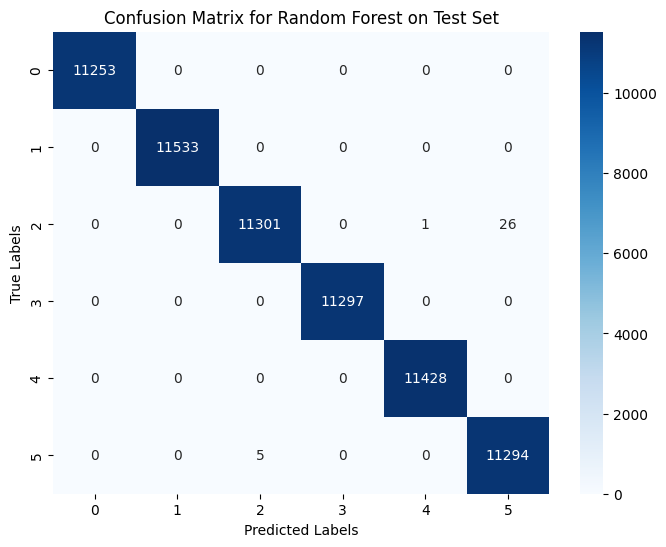

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11253
           1       1.00      1.00      1.00     11533
           2       1.00      1.00      1.00     11328
           3       1.00      1.00      1.00     11297
           4       1.00      1.00      1.00     11428
           5       1.00      1.00      1.00     11299

    accuracy                           1.00     68138
   macro avg       1.00      1.00      1.00     68138
weighted avg       1.00      1.00      1.00     68138



In [55]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test_rf)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest on Test Set')
plt.show()

# Print classification report for detailed metrics
print(classification_report(y_test, y_pred_test_rf))


Import Required Libraries

In [56]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Save Confusion Matrix as CSV

In [57]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test_rf)

# Convert confusion matrix to a DataFrame for better saving
cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))

# Save confusion matrix as a CSV file
cm_df.to_csv('confusion_matrix_rf.csv', index=True)

print("Confusion matrix saved to 'confusion_matrix_rf.csv'")


Confusion matrix saved to 'confusion_matrix_rf.csv'


Save Classification Report to a Text File

In [58]:
# Generate classification report
class_report = classification_report(y_test, y_pred_test_rf)

# Save the classification report to a text file
with open('classification_report_rf.txt', 'w') as f:
    f.write(class_report)

print("Classification report saved to 'classification_report_rf.txt'")


Classification report saved to 'classification_report_rf.txt'


Visualize and Save the Confusion Matrix Plot

Confusion matrix plot saved to 'confusion_matrix_rf_plot.png'


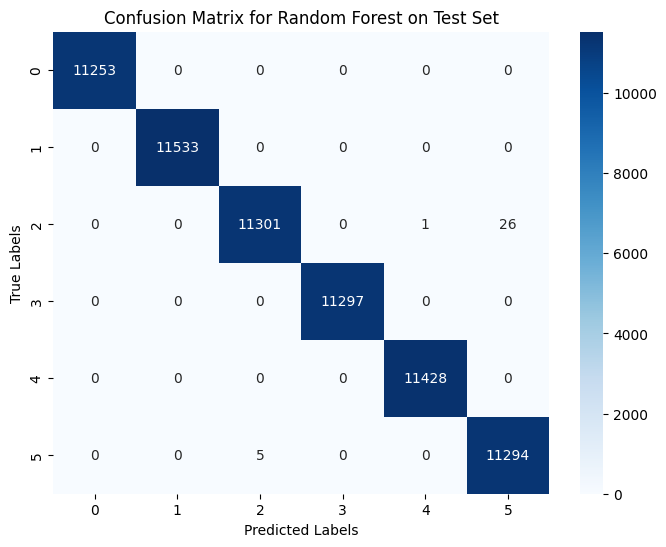

In [59]:
# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest on Test Set')

# Save the plot as an image file
plt.savefig('confusion_matrix_rf_plot.png')

print("Confusion matrix plot saved to 'confusion_matrix_rf_plot.png'")
plt.show()


Model save

In [10]:
# Save the model's state_dict
torch.save(model.state_dict(), 'simclr_model.pth')

# Save the random forest model using joblib (for scikit-learn models)
import joblib
joblib.dump(rf_model, 'random_forest_model.pkl')

print("Models saved successfully!")


NameError: name 'X_train' is not defined

In [ ]:
# Create a new instance of the model
new_model = SimCLR(input_dim, hidden_dim, output_dim, projection_dim)

# Load the saved state_dict into the new model
new_model.load_state_dict(torch.load('simclr_model.pth'))

# Don't forget to set the model to evaluation mode if you're using it for inference
new_model.eval()

print("Model loaded successfully!")
